## This compares to DoubleBracketIteration whenever possible

In [1]:
import inspect
import sys
sys.path.append("../../tests")
from test_models_dbi import *
def print_function_source_code( func ):
    out = inspect.getsourcelines(func)  
    from functools import reduce
    print(reduce(str.__add__, out[0]))

In [2]:
import qibo
backend = qibo.backends.construct_backend("numpy")
qibo.set_backend("numpy")
nqubits = 3

[Qibo 0.2.7|INFO|2024-04-29 17:10:31]: Using numpy backend on /CPU:0


# Test frame shifted oracles

In a group commutator iteration (GCI) we have
$$J_{k+1}= U_k^\dagger J_k U_k$$
which is obtained by a product formula for $U_k$.
We will use two examples
$$A_k = e^{is D} e^{is J_k} e^{-isD}$$
and
$$B_k = e^{-is J_k}e^{is D} e^{is J_k} e^{-isD}$$
In both cases $D$ is fixed, which amounts to a product formula approximation of the BHMM scheme.

For $B_k$ we have the group commutator bound, see below. For $A_k$ we will have that
$$J_{k+1}= A_k^\dagger J_k A_k= B_k^\dagger J_k B_k$$
because of a reduction by means of a commutator vanishing (the ordering was chosen on purpose).

This means that $A_k$ and $B_k$ schemes should give the same `GroupCommutatorIterationWithEvolutionOracles.h`. Additionally that should be also `DoubleBracketIteration.h` as long as the ordering is correct.

If we operate in the `EvolutionOracleType.hamiltonian_simulation` there will be deviations based on the `EvolutionOracle.eps_trottersuzuki` threshold.


In [3]:
print_function_source_code(test_gci_frame_shifted_oracles) 

test_gci_frame_shifted_oracles(backend,nqubits)

[Qibo 0.2.7|WARNING|2024-04-29 17:10:31]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-04-29 17:10:31]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


def test_gci_frame_shifted_oracles(backend,nqubits,mode_evolution_oracle = EvolutionOracleType.hamiltonian_simulation):
    """In a group commutator iteration (GCI) we have
$$J_{k+1}= U_k^\dagger J_k U_k$$
which is obtained by a product formula for $U_k$.
We will use two examples
$$A_k = e^{is D} e^{is J_k} e^{-isD}$$

This means that $A_k$ and $B_k$ schemes should give the same `Groupand
$$B_k = e^{-is J_k}e^{is D} e^{is J_k} e^{-isD}$$
In both cases $D$ is fixed, which amounts to a product formula approximation of the BHMM scheme.

For $B_k$ we have the group commutator bound, see below. For $A_k$ we will have that
$$J_{k+1}= A_k^\dagger J_k A_k= B_k^\dagger J_k B_k$$
because of a reduction by means of a commutator vanishing (the ordering was chosen on purpose).
CommutatorIterationWithEvolutionOracles.h`. Additionally that should be also `DoubleBracketIteration.h` as long as the ordering is correct.

If we operate in the `EvolutionOracleType.hamiltonian_simulation` there will be devi

The regular implementation in `DoubleBracketIteration` should be viewed as using classical dynamic programming: memoization of the updated Hamiltonian is used explicitly. Instead, using `FrameShiftedEvolutionOracle` we can store a sequence of recursive rotations such that eventually the iteration gives the same result.
    This function tests numerical agreement using the numpy backend.

In [4]:
print_function_source_code(test_gci_implementation_normal_and_oracles)

        
test_gci_implementation_normal_and_oracles(backend,nqubits, mode_evolution_oracle = EvolutionOracleType.numerical)

[Qibo 0.2.7|WARNING|2024-04-29 17:10:34]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-04-29 17:10:34]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


def test_gci_implementation_normal_and_oracles(backend,nqubits,mode_evolution_oracle = EvolutionOracleType.numerical):
    """The regular implementation in `DoubleBracketIteration` should be viewed as using classical dynamic programming: memoization of the updated Hamiltonian is used explicitly. Instead, using `FrameShiftedEvolutionOracle` we can store a sequence of recursive rotations such that eventually the iteration gives the same result.
    This function tests numerical agreement using the numpy backend.
    """
    h_x = SymbolicHamiltonian(
            symbols.X(0)
        + symbols.Z(0) * symbols.X(1)
        + symbols.Y(2)
        + symbols.Y(1) * symbols.Y(2),
        nqubits=3,
    ) 
    d_0 = SymbolicHamiltonian(symbols.Z(0), nqubits=3)
    h_input = h_x + d_0

    dbi = DoubleBracketIteration(deepcopy(h_input.dense))

    evolution_oracle = EvolutionOracle(h_input, "ZX", mode_evolution_oracle)   
    gci = GroupCommutatorIterationWithEvolutionOracles( deepcopy(evolution_

#### Remark:
If Hamiltonian_simulation is used as the mode then the eps_trottersuzuki might be too law to pass this assertion.

# Check the numerical mode of evolution oracles

This is testing the following:

`dbi_exact` runs $V_{exact} = e^{-sW}$ and rotates $H_1 = V_{exact}^\dagger H_0 V_{exact}$.

`dbi_GC` runs $V_{GC} = GC$ and rotates $K_1 = V_{GC}^\dagger H_0 V_{GC}$.

We assert that dbi_exact and dbi_GC should be within the approximation bound of the GC
$$||J_1-H_1||\le2 ||H_0||\,||R-V||\le C ||H_0|| s^{3/2}$$

`gci` runs $V_{EO,GC} = GC$ and rotates $J_1 = V_{EO,GC}^\dagger H_0 V_{EO,GC}$.

We assert that gci and dbi2 should be within machine precision for the correct sorting.
$$||J_1-K_1||\le2 ||H_0||\,||R-Q||\le \epsilon$$




In [5]:
print_function_source_code(test_gci_evolution_oracles_types_numerical)

def test_gci_evolution_oracles_types_numerical(nqubits,backend,t_step, eps):
    """

    This is testing the following:

    `dbi_exact` runs $V_{exact} = e^{-sW}$ and rotates $H_1 = V_{exact}^\dagger H_0 V_{exact}$.

    `dbi_GC` runs $V_{GC} = GC$ and rotates $K_1 = V_{GC}^\dagger H_0 V_{GC}$.

    We assert that dbi_exact and dbi_GC should be within the approximation bound of the GC
    $$||J_1-H_1||\le2 ||H_0||\,||R-V||\le C ||H_0|| s^{3/2}$$

    `gci` runs $V_{EO,GC} = GC$ and rotates $J_1 = V_{EO,GC}^\dagger H_0 V_{EO,GC}$.

    We assert that gci and dbi2 should be within machine precision for the correct sorting.
    $$||J_1-K_1||\le2 ||H_0||\,||R-Q||\le \epsilon$$
    """
    from numpy.linalg import norm
    h_x = SymbolicHamiltonian(
        symbols.X(0)
        + symbols.Z(0) * symbols.X(1)
        + symbols.Y(2)
        + symbols.Y(1) * symbols.Y(2),
        nqubits=3,
    )
    d_0 = SymbolicHamiltonian(symbols.Z(0), nqubits=3)
    h_input = h_x + d_0

    dbi = DoubleB

In [6]:
t_step =0.01
eps = 1e-2
test_gci_evolution_oracles_types_numerical(nqubits,backend,t_step, eps)



[Qibo 0.2.7|WARNING|2024-04-29 17:10:34]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-04-29 17:10:34]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


## Check numerical GCI with evolution oracles against `DoubleBracketIteration`

Basically we have again a bound for how $H_k$ differs from $J_k$ for various duriations of the DBR.

The plots below show that the GCI implementation for 1 step agrees precisely

[Qibo 0.2.7|WARNING|2024-04-29 17:10:34]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
/home/marek/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
[Qibo 0.2.7|WARNING|2024-04-29 17:10:35]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


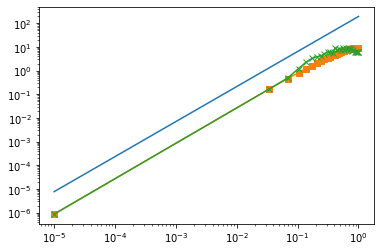

In [7]:
h_x = SymbolicHamiltonian(
        symbols.X(0)
    + symbols.Z(0) * symbols.X(1)
    + symbols.Y(2)
    + symbols.Y(1) * symbols.Y(2),
    nqubits=3,
)
d_0 = SymbolicHamiltonian(symbols.Z(0), nqubits=3)
h_input = h_x + d_0

dbi = DoubleBracketIteration(deepcopy(h_input.dense))
dbi.mode = DoubleBracketGeneratorType.single_commutator

evolution_oracle = EvolutionOracle(h_input, "ZX",
                        mode_evolution_oracle = EvolutionOracleType.numerical)    

evolution_oracle_diagonal_target =  EvolutionOracle(d_0, "D0",
           mode_evolution_oracle = EvolutionOracleType.numerical)

gci = GroupCommutatorIterationWithEvolutionOracles( deepcopy(evolution_oracle ))


import matplotlib.pyplot as plt
from numpy.linalg import norm
norms  = []
norms2  = []
norms_bound = []
times = np.linspace(1e-5,1,30)
for r in times:
    dbi(r, d = d_0.dense.matrix, mode = DoubleBracketGeneratorType.single_commutator )
    h_r = dbi.h.matrix
    dbi.h = deepcopy(h_input.dense) 
    dbi(r, d = d_0.dense.matrix, mode = DoubleBracketGeneratorType.group_commutator )
    k_r = dbi.h.matrix
    dbi.h = deepcopy(h_input.dense) 
    gci(r, diagonal_association= evolution_oracle_diagonal_target )
    j_r = gci.h.matrix
    gci.h = deepcopy(h_input.dense) 
    
    w = dbi.commutator(h_input.dense.matrix,d_0.dense.matrix)
    norms_bound.append(norm(h_input.dense.matrix)*r**1.48 * (
        np.linalg.norm(dbi.commutator(h_input.dense.matrix,w)) + np.linalg.norm(dbi.commutator(d_0.matrix,w))
    ))
   
    norms.append(norm(h_r -k_r ))
    norms2.append(norm(h_r-j_r))
    
plt.loglog(times, norms_bound)
plt.loglog(times,norms, 
          '-s')
plt.loglog(times,norms2, '-x')

### This is captured in the following test
(we restrict to both group commutator modes as for more steps there will be deviations)

In [8]:

evolution_oracle = EvolutionOracle(h_input, "ZX",
                    mode_evolution_oracle = EvolutionOracleType.numerical)    
d_0 = SymbolicHamiltonian(symbols.Z(0), nqubits=3)
evolution_oracle_diagonal_target =  EvolutionOracle(d_0, "D0",
           mode_evolution_oracle = EvolutionOracleType.numerical)

gci = GroupCommutatorIterationWithEvolutionOracles( deepcopy(evolution_oracle ))
#gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator

u_gc_from_oracles = gci.group_commutator( t_step, evolution_oracle_diagonal_target )   
u_gci = u_gc_from_oracles['forwards']

assert norm(u_gci.conj().T - u_gc_from_oracles['backwards']) < 1e-12


v_exact = dbi.eval_dbr_unitary(t_step, d=d_0.dense.matrix, mode=DoubleBracketGeneratorType.single_commutator)
w = dbi.commutator(h_input.dense.matrix,d_0.dense.matrix)
norms_bound = 0.5*t_step**1.48 * (
    np.linalg.norm(dbi.commutator(h_input.dense.matrix,w)) + np.linalg.norm(dbi.commutator(d_0.matrix,w))
)
assert norm(v_exact - u_gci) < norms_bound
u_gcr = gci.eval_gcr_unitary(t_step,evolution_oracle_diagonal_target )
assert norm(v_exact - u_gcr) < norms_bound
print(norm(v_exact-u_gcr))
print(norm(dbi.eval_dbr_unitary(t_step, d=d_0.dense.matrix, mode=DoubleBracketGeneratorType.group_commutator)-u_gci))
gci(t_step, diagonal_association= evolution_oracle_diagonal_target )

j_1 = gci.iterated_hamiltonian_evolution_oracle.h.matrix
assert norm(dbi.h.matrix-j_1) < 2 * norm(h_input.dense.matrix) * norms_bound   


[Qibo 0.2.7|WARNING|2024-04-29 17:10:36]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0.007946732303441253
0.0


### Next many steps: the `DoubleBracketIteration` implementation agrees with evolution oracles for the gc mode. In the exact commutator exponential a deviation builds up

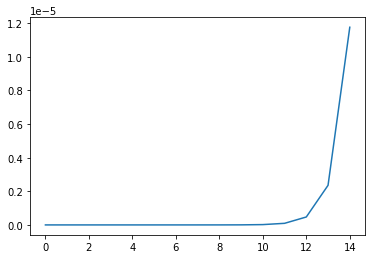

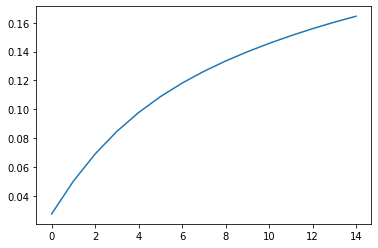

In [9]:
r=0.01

norms_it  = []
norms_it2  = []
dbi = DoubleBracketIteration(deepcopy(h_input.dense))
dbi2 = DoubleBracketIteration(deepcopy(h_input.dense))
gci = GroupCommutatorIterationWithEvolutionOracles( deepcopy(evolution_oracle ))
for _ in range(15):
    dbi(r, d = d_0.dense.matrix, mode = DoubleBracketGeneratorType.single_commutator )
    dbi2(r, d = d_0.dense.matrix, mode = DoubleBracketGeneratorType.group_commutator )
    gci(r, diagonal_association= evolution_oracle_diagonal_target )
    h_r = dbi.h.matrix
    k_r = dbi2.h.matrix
    j_r = gci.h.matrix
    norms_it.append(norm(k_r-j_r))
    norms_it2.append(norm(h_r-j_r))    
plt.plot(norms_it)
plt.show()
plt.plot(norms_it2)

## Simple test of group commutator

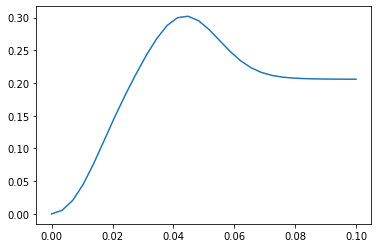

In [10]:
def test_exact_dbr_vs_gc_bound(nqubits,backend):
    dbi = DoubleBracketIteration(deepcopy(h_input.dense))
    dbi.mode = DoubleBracketGeneratorType.single_commutator


    dbi2 = DoubleBracketIteration(deepcopy(h_input.dense))
    dbi2.mode = DoubleBracketGeneratorType.group_commutator

    import matplotlib.pyplot as plt
    norms  = []
    for r in np.linspace(1e-5,0.1,30):
        dbi(r, d=d_0.dense.matrix)
        dbi2(r, d=d_0.dense.matrix)
        norms.append(norm(dbi.h.matrix- dbi2.h.matrix))
    
    #plt.plot(np.linspace(1e-5,.1,30), [x**1.5*1000 for x in np.linspace(1e-5,.1,30)])
    plt.plot(np.linspace(1e-5,.1,30),norms)
test_exact_dbr_vs_gc_bound(nqubits,backend)

## Check the GC bound is valid and corectly implemented in DoubleBracketIteration

The bound is $$||e^{-t[D,H]}-GC(s=\sqrt{t})||\le t^{3/2}(||[H,[D,H]||+||[D,[D,H]]||$$


In [11]:
print_function_source_code(test_double_bracket_iteration_eval_dbr_unitary)

@pytest.mark.parametrize("nqubits", [3])
def test_double_bracket_iteration_eval_dbr_unitary(backend, nqubits):
    r"""The bound is $$||e^{-[D,H]}-GC||\le s^{3/2}(||[H,[D,H]||+||[D,[D,H]]||$$ which we check by a loglog fit."""
    h0 = random_hermitian(2**nqubits, backend=backend)
    d = backend.cast(np.diag(np.diag(backend.to_numpy(h0))))
    dbi = DoubleBracketIteration(
        Hamiltonian(nqubits, h0, backend=backend),
        mode=DoubleBracketGeneratorType.group_commutator,
    )

    times = np.linspace(0.001, 0.01, 10)
    norms = []
    norms_bound = []
    for s in times:
        u = dbi.eval_dbr_unitary(
            s, d=d, mode=DoubleBracketGeneratorType.single_commutator
        )
        v = dbi.eval_dbr_unitary(
            s, d=d, mode=DoubleBracketGeneratorType.group_commutator
        )

        norms.append(np.linalg.norm(u - v) )
        w = dbi.commutator(h0,d)
        norms_bound.append(0.5*s**1.48 * (
            np.linalg.norm(dbi.commutator(h0,w)) + np.linalg.

In [12]:
test_double_bracket_iteration_eval_dbr_unitary(backend, nqubits)

### We repeat the function in order to plot the bound

In [13]:
r"""The bound is $$||e^{-[D,H]}-GC||\le s^{3/2}(||[H,[D,H]||+||[D,[D,H]]||$$"""
h0 = random_hermitian(2**nqubits, backend=backend)
d = backend.cast(np.diag(np.diag(backend.to_numpy(h0))))
dbi = DoubleBracketIteration(
    Hamiltonian(nqubits, h0, backend=backend),
    mode=DoubleBracketGeneratorType.group_commutator,
)

times = np.linspace(0.001, 0.01, 10)
norms = []
norms_bound = []
for s in times:
    u = dbi.eval_dbr_unitary(
        s, d=d, mode=DoubleBracketGeneratorType.single_commutator
    )
    v = dbi.eval_dbr_unitary(
        s, d=d, mode=DoubleBracketGeneratorType.group_commutator
    )

    norms.append(np.linalg.norm(u - v) )
    w = dbi.commutator(h0,d)
    norms_bound.append(0.5*s**1.48 * (
        np.linalg.norm(dbi.commutator(h0,w)) + np.linalg.norm(dbi.commutator(d,w))
    ))
    assert np.linalg.norm(u - v) < 10 * s**1.49 * (
            np.linalg.norm(h0) + np.linalg.norm(d)
        ) * np.linalg.norm(h0) * np.linalg.norm(d)

Unfortunately we cannot assume that 
`assert popt[0] < 1.51`
because in principle data satisfying the bound can be ragged and could have a large slope.
When the bound is saturated, however, then the following fit works:

In [14]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit( (lambda x, a, b: a*x+b ), [np.log(t) for t in times], [np.log(n) for n in norms])
assert popt[0] < 1.51

In practice that assertion usually goes through. We check this further by these plots

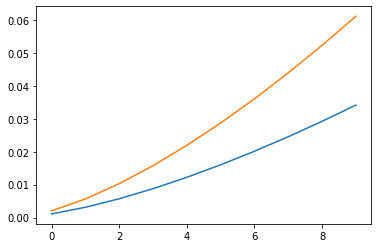

In [15]:
import matplotlib.pyplot as plt
plt.plot(norms)
plt.plot(norms_bound)

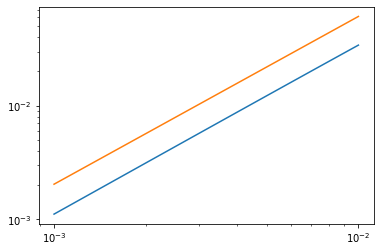

In [16]:
plt.loglog(times,norms)
plt.loglog(times,norms_bound)

Usually random Hamiltonian matrices give something $a\approx 1.49$

In [17]:
popt

array([1.49083955, 3.49249848])